In [1]:
import xgboost as xgb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
from sklearn.model_selection import train_test_split
import contextily as cx
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
from fastshap import KernelExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = gpd.read_file('../../data/NYC_education.gpkg')

In [4]:
data = data.dropna(subset=['PER_ASIAN', 'PER_BLACK', 'PER_WHITE', 'mean_inc', 'pop1619', 'over3', 'sub18', 'GENDER_PAR', 'popdens', 'college'])

In [5]:
X = data[['PER_ASIAN', 'PER_BLACK', 'PER_WHITE', 'mean_inc', 'pop1619', 'over3', 'sub18', 'GENDER_PAR', 'popdens', 'lon', 'lat']]
y = data['phd'].astype(int)
loc = data[['lon', 'lat']]
geometry = data['geometry']

In [6]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp, geo_train, geo_temp = train_test_split(X, y, loc, geometry, train_size=0.6, random_state=42)

In [7]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test, geo_calib, geo_test = train_test_split(X_temp, y_temp, loc_temp, geo_temp, train_size=0.5, random_state=42)

In [8]:
model = xgb.XGBRegressor(n_estimators=300, max_depth=2, min_child_weight=1.0, colsample_bytree=1.0, objective='count:poisson', base_score=100).fit(X_train.values, y_train.values)

In [9]:
model.score(X_test, y_test)

0.7407352924346924

In [10]:
def shap_value_f(x):
    explainer_ = KernelExplainer(model.predict, x)
    explainer_.stratify_background_set(5)
    result = explainer_.calculate_shap_values(x, verbose=False, background_fold_to_use=0)
    return result[:, :-1]

In [12]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=0.15,
                                      feature_names=X.columns,
                                      shap_value_f=None)

In [13]:
results = explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test)

100%|██████████| 444/444 [06:27<00:00,  1.15it/s]


Explaining Variables


In [15]:
from typing import List
from matplotlib.colors import LinearSegmentedColormap

In [34]:
def plot_shap_values_with_uncertainty(feature_values: np.ndarray, shap_values: np.ndarray, geo_uncertainty: np.ndarray,
                                      feature_names: List[str], filename: str = None):
    plt.style.use('default')
    plt.rcParams['font.size'] = 12
    fig_height = 0.75 * len(feature_names)
    fig_width = fig_height * 1.1
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='#ffffff', dpi=300)
    lower_bound_list = shap_values - geo_uncertainty
    upper_bound_list = shap_values + geo_uncertainty
    point_colors = ['#a50f15' if e >= 0 else '#08519c' for e in shap_values]
    bar_colors = ['#d8a6a6' if e >= 0 else '#8cc5e3' for e in shap_values]
    gradient_colors = [['#fee5d9', '#de2d26', '#fee5d9'] if e >= 0 else ['#c6dbef', '#3182bd', '#c6dbef'] for e in
                       shap_values]
    # labels = [f'+{self._format_number_based_on_magnitude(e)}' if e >= 0 else f'{self._format_number_based_on_magnitude(e)}' for e in shap_values_i]
    y_positions = np.arange(len(feature_names))

    ax.axvline(0, color='#a1a1a1', linestyle='--')

    num_feature_names = len(feature_names)
    height = 0.2
    for y, x, low, high, point_color, bar_color, gradient_color in zip(y_positions, shap_values, lower_bound_list,
                                                                       upper_bound_list, point_colors, bar_colors,
                                                                       gradient_colors):
        # ax.plot([low, high], [y, y], color='#454545', linewidth=1.5, solid_capstyle='butt', zorder=1)
        # ax.plot([low, low], [y - height, y + height], color='#454545', linewidth=1.5, solid_capstyle='butt', zorder=1)
        # ax.plot([high, high], [y - height, y + height], color='#454545', linewidth=1.5, solid_capstyle='butt',
        #         zorder=1)
        bar_height = 2 * height

        # error_bar = Rectangle((low, y - height), high - low, bar_height, facecolor=bar_color, alpha=0.5)
        # ax.add_patch(error_bar)
        gradient = np.linspace(0, 1, 256).reshape(1, -1)
        extent = [low, high, y - height, y + height]
        cmap = LinearSegmentedColormap.from_list('gradient', gradient_color)
        ax.imshow(gradient, aspect='auto', cmap=cmap, extent=extent, alpha=0.8)
        # ax.plot(x, y, color=point_color, marker='o', markersize=12, zorder=2)
        ax.vlines(x, y - height, y + height, colors=point_color, linewidths=5)
    plt.xlabel('Importance')

    y_ticks = []
    for name, value in zip(feature_names, feature_values):
        value = np.round(value, decimals=4)
        y_ticks.append(f'{name} = {value}')

    plt.yticks(y_positions, y_ticks)

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
feature_names = X.columns

In [18]:
gdf = results.to_gdf()

In [19]:
feature_values = []
shap_values = []
geo_uncertainty = []
i = 100

for feature_name in feature_names:
    feature_values.append(gdf[f'{feature_name}_value'].values[i])
    feature_value = gdf[f'{feature_name}_value'].values[i]
    print(f'{feature_name}: {feature_value}')
    shap_values.append(gdf[f'{feature_name}_shap'].values[i])
    geo_uncertainty.append(gdf[f'{feature_name}_geo_uncertainty'].values[i])

feature_values = np.array(feature_values).astype(float)
shap_values = np.array(shap_values).astype(float)
geo_uncertainty = np.array(geo_uncertainty).astype(float)

PER_ASIAN: 0.03
PER_BLACK: 0.01
PER_WHITE: 0.95
mean_inc: 50662.0
pop1619: 133.0
over3: 1854.0
sub18: 569.0
GENDER_PAR: 1.0183
popdens: 22879.15
lon: -73.95196200236046
lat: 40.616474401016994


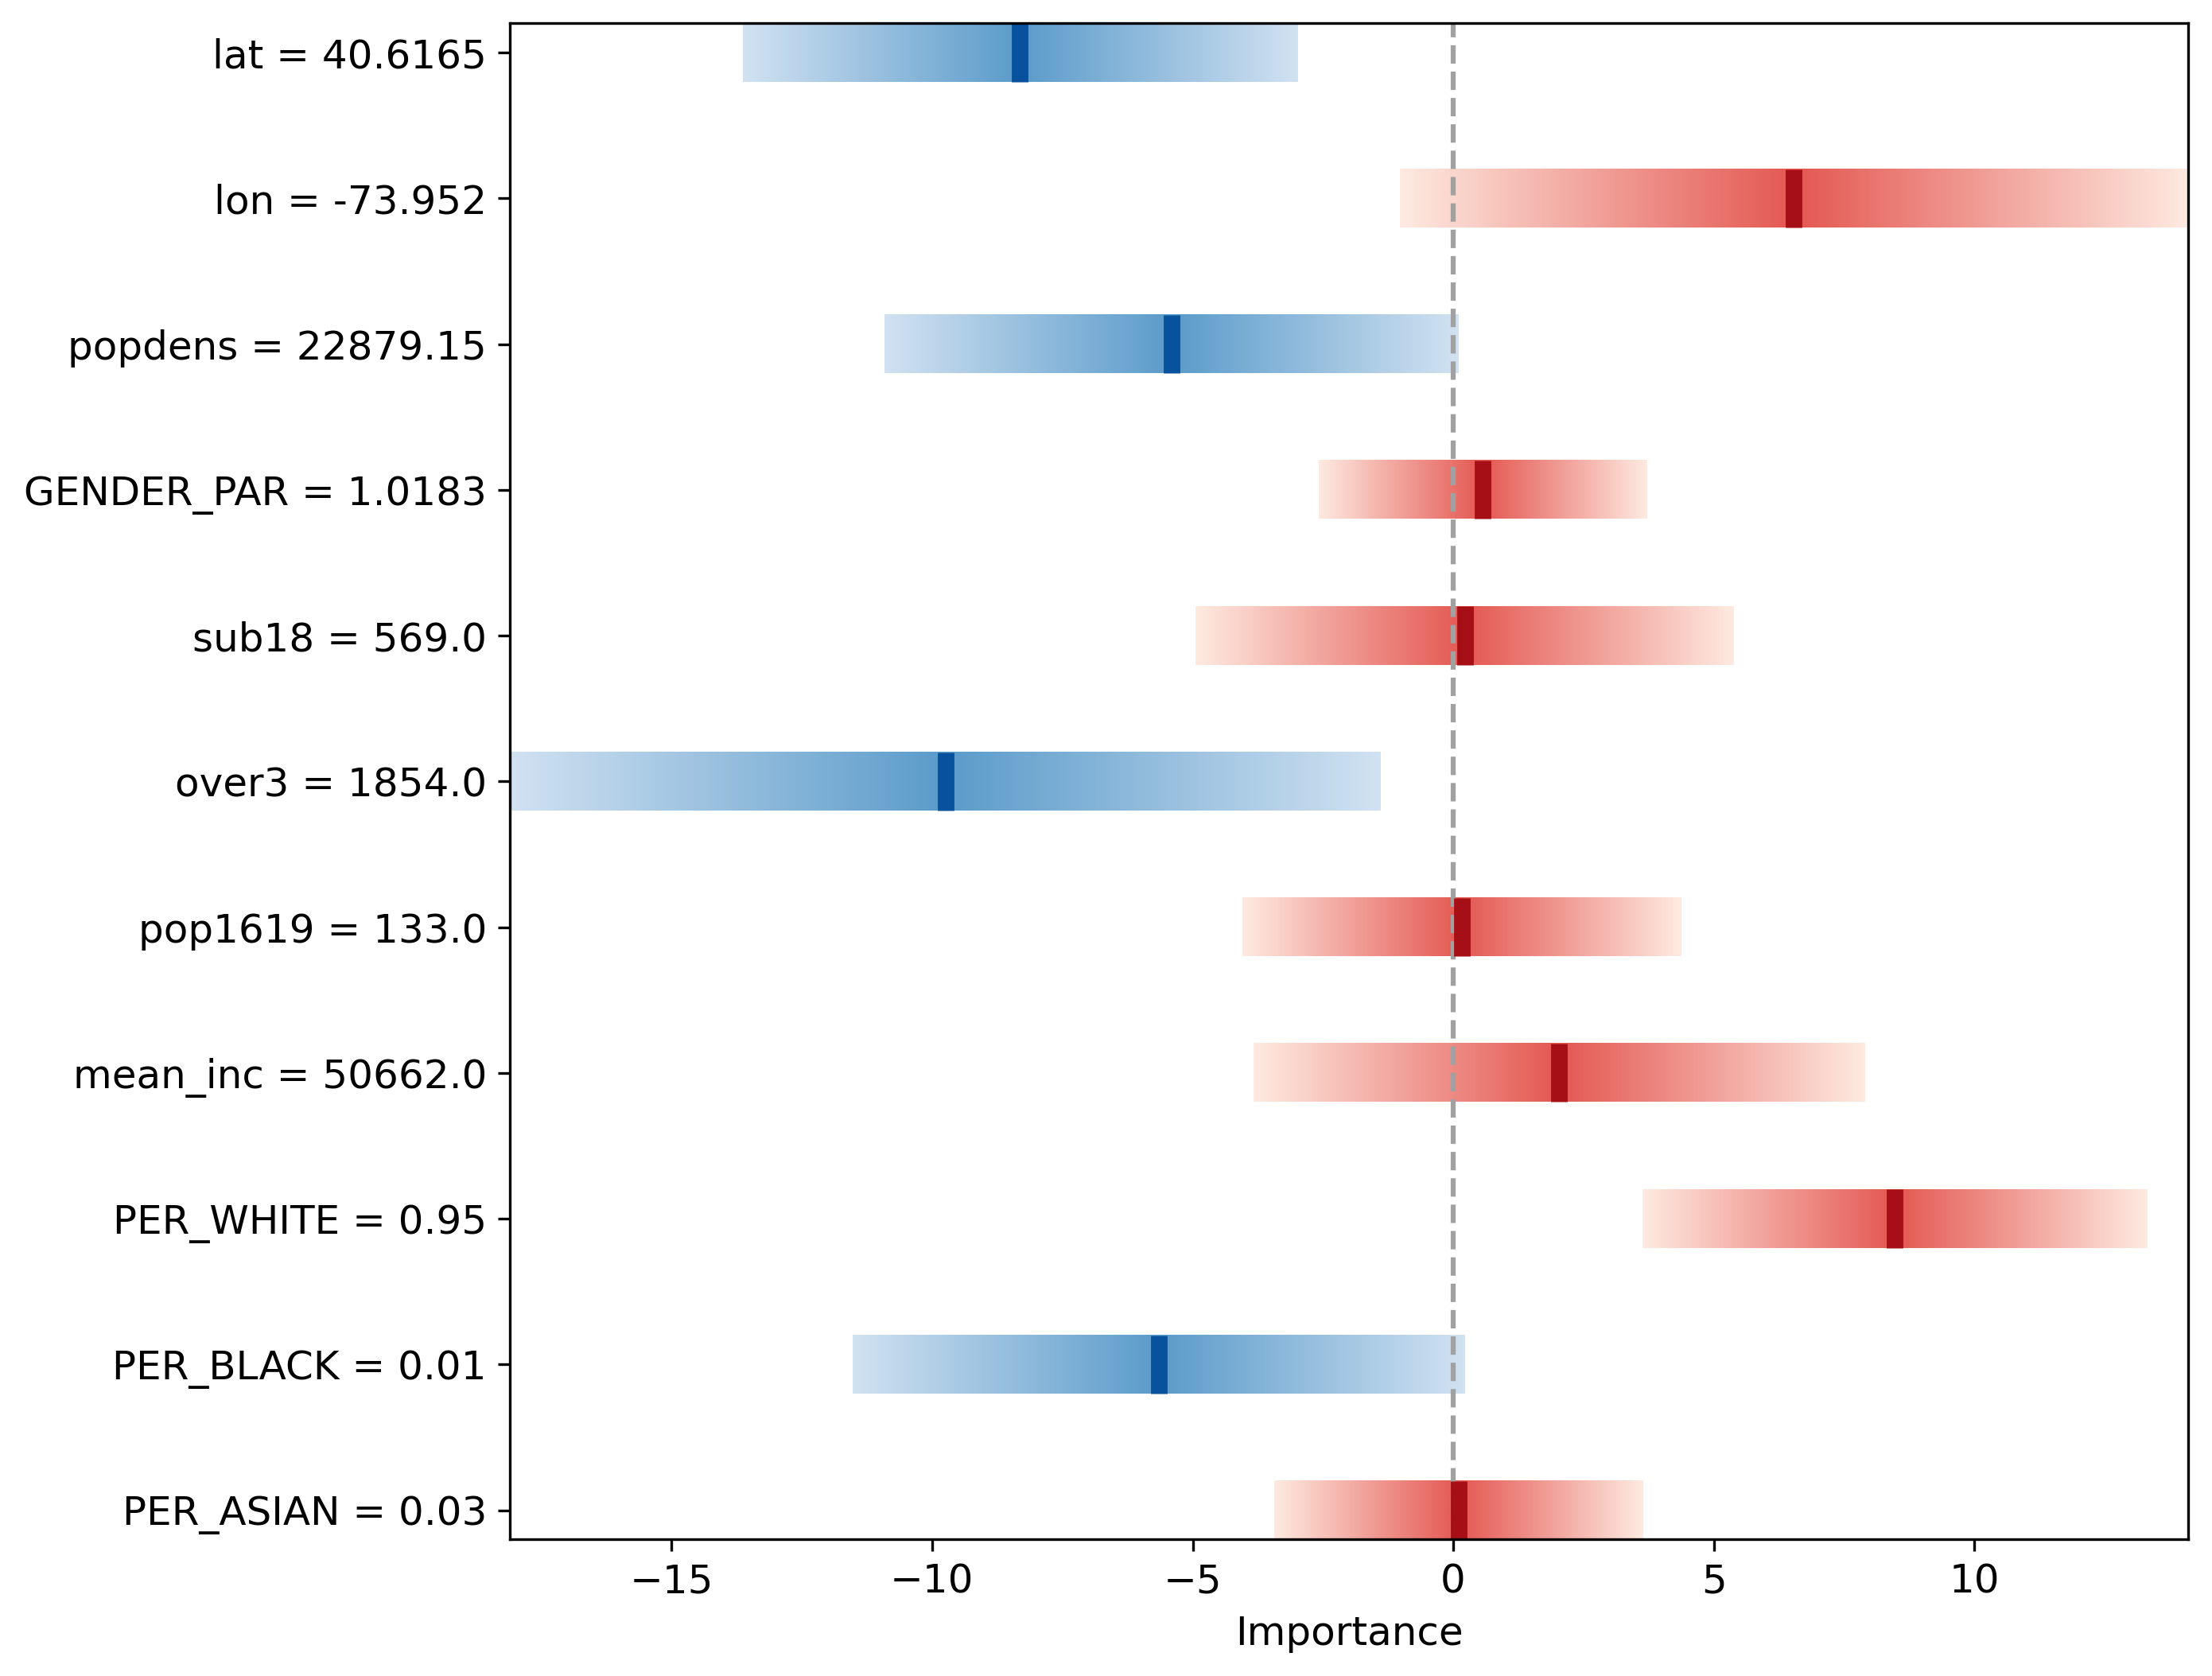

In [35]:
plot_shap_values_with_uncertainty(feature_values, shap_values, geo_uncertainty, feature_names, filename='./shap_values_with_uncertainty.pdf')

In [29]:
def plot_shap_values_without_uncertainty(feature_values: np.ndarray, shap_values: np.ndarray, geo_uncertainty: np.ndarray,
                                      feature_names: List[str], filename: str = None):
    plt.style.use('default')
    plt.rcParams['font.size'] = 12
    fig_height = 0.75 * len(feature_names)
    fig_width = fig_height * 1.1
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='#ffffff', dpi=300)
    lower_bound_list = shap_values - geo_uncertainty
    upper_bound_list = shap_values + geo_uncertainty
    point_colors = ['#a50f15' if e >= 0 else '#08519c' for e in shap_values]
    bar_colors = ['#d8a6a6' if e >= 0 else '#8cc5e3' for e in shap_values]
    gradient_colors = [['#fee5d9', '#de2d26', '#fee5d9'] if e >= 0 else ['#c6dbef', '#3182bd', '#c6dbef'] for e in
                       shap_values]
    # labels = [f'+{self._format_number_based_on_magnitude(e)}' if e >= 0 else f'{self._format_number_based_on_magnitude(e)}' for e in shap_values_i]
    y_positions = np.arange(len(feature_names))

    ax.axvline(0, color='#a1a1a1', linestyle='--')

    num_feature_names = len(feature_names)
    height = 0.2

    ax.barh(y_positions, shap_values, color=bar_colors)
    # for y, x, low, high, point_color, bar_color, gradient_color in zip(y_positions, shap_values, lower_bound_list,
    #                                                                    upper_bound_list, point_colors, bar_colors,
    #                                                                    gradient_colors):
        # ax.plot([low, high], [y, y], color='#454545', linewidth=1.5, solid_capstyle='butt', zorder=1)
        # ax.plot([low, low], [y - height, y + height], color='#454545', linewidth=1.5, solid_capstyle='butt', zorder=1)
        # ax.plot([high, high], [y - height, y + height], color='#454545', linewidth=1.5, solid_capstyle='butt',
        #         zorder=1)
        # bar_height = 2 * height

        # error_bar = Rectangle((low, y - height), high - low, bar_height, facecolor=bar_color, alpha=0.5)
        # ax.add_patch(error_bar)
        # gradient = np.linspace(0, 1, 256).reshape(1, -1)
        # extent = [0, x, y - height, y + height]
        # # cmap = LinearSegmentedColormap.from_list('gradient', gradient_color)
        # ax.imshow(gradient, aspect='auto', cmap=bar_color, extent=extent, alpha=0.8)
        # ax.plot(x, y, color=point_color, marker='o', markersize=12, zorder=2)
        # ax.vlines(x, y - height, y + height, colors=point_color, linewidths=5)
    plt.xlabel('Importance')

    y_ticks = []
    for name, value in zip(feature_names, feature_values):
        value = np.round(value, decimals=4)
        y_ticks.append(f'{name} = {value}')

    plt.yticks(y_positions, y_ticks)

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

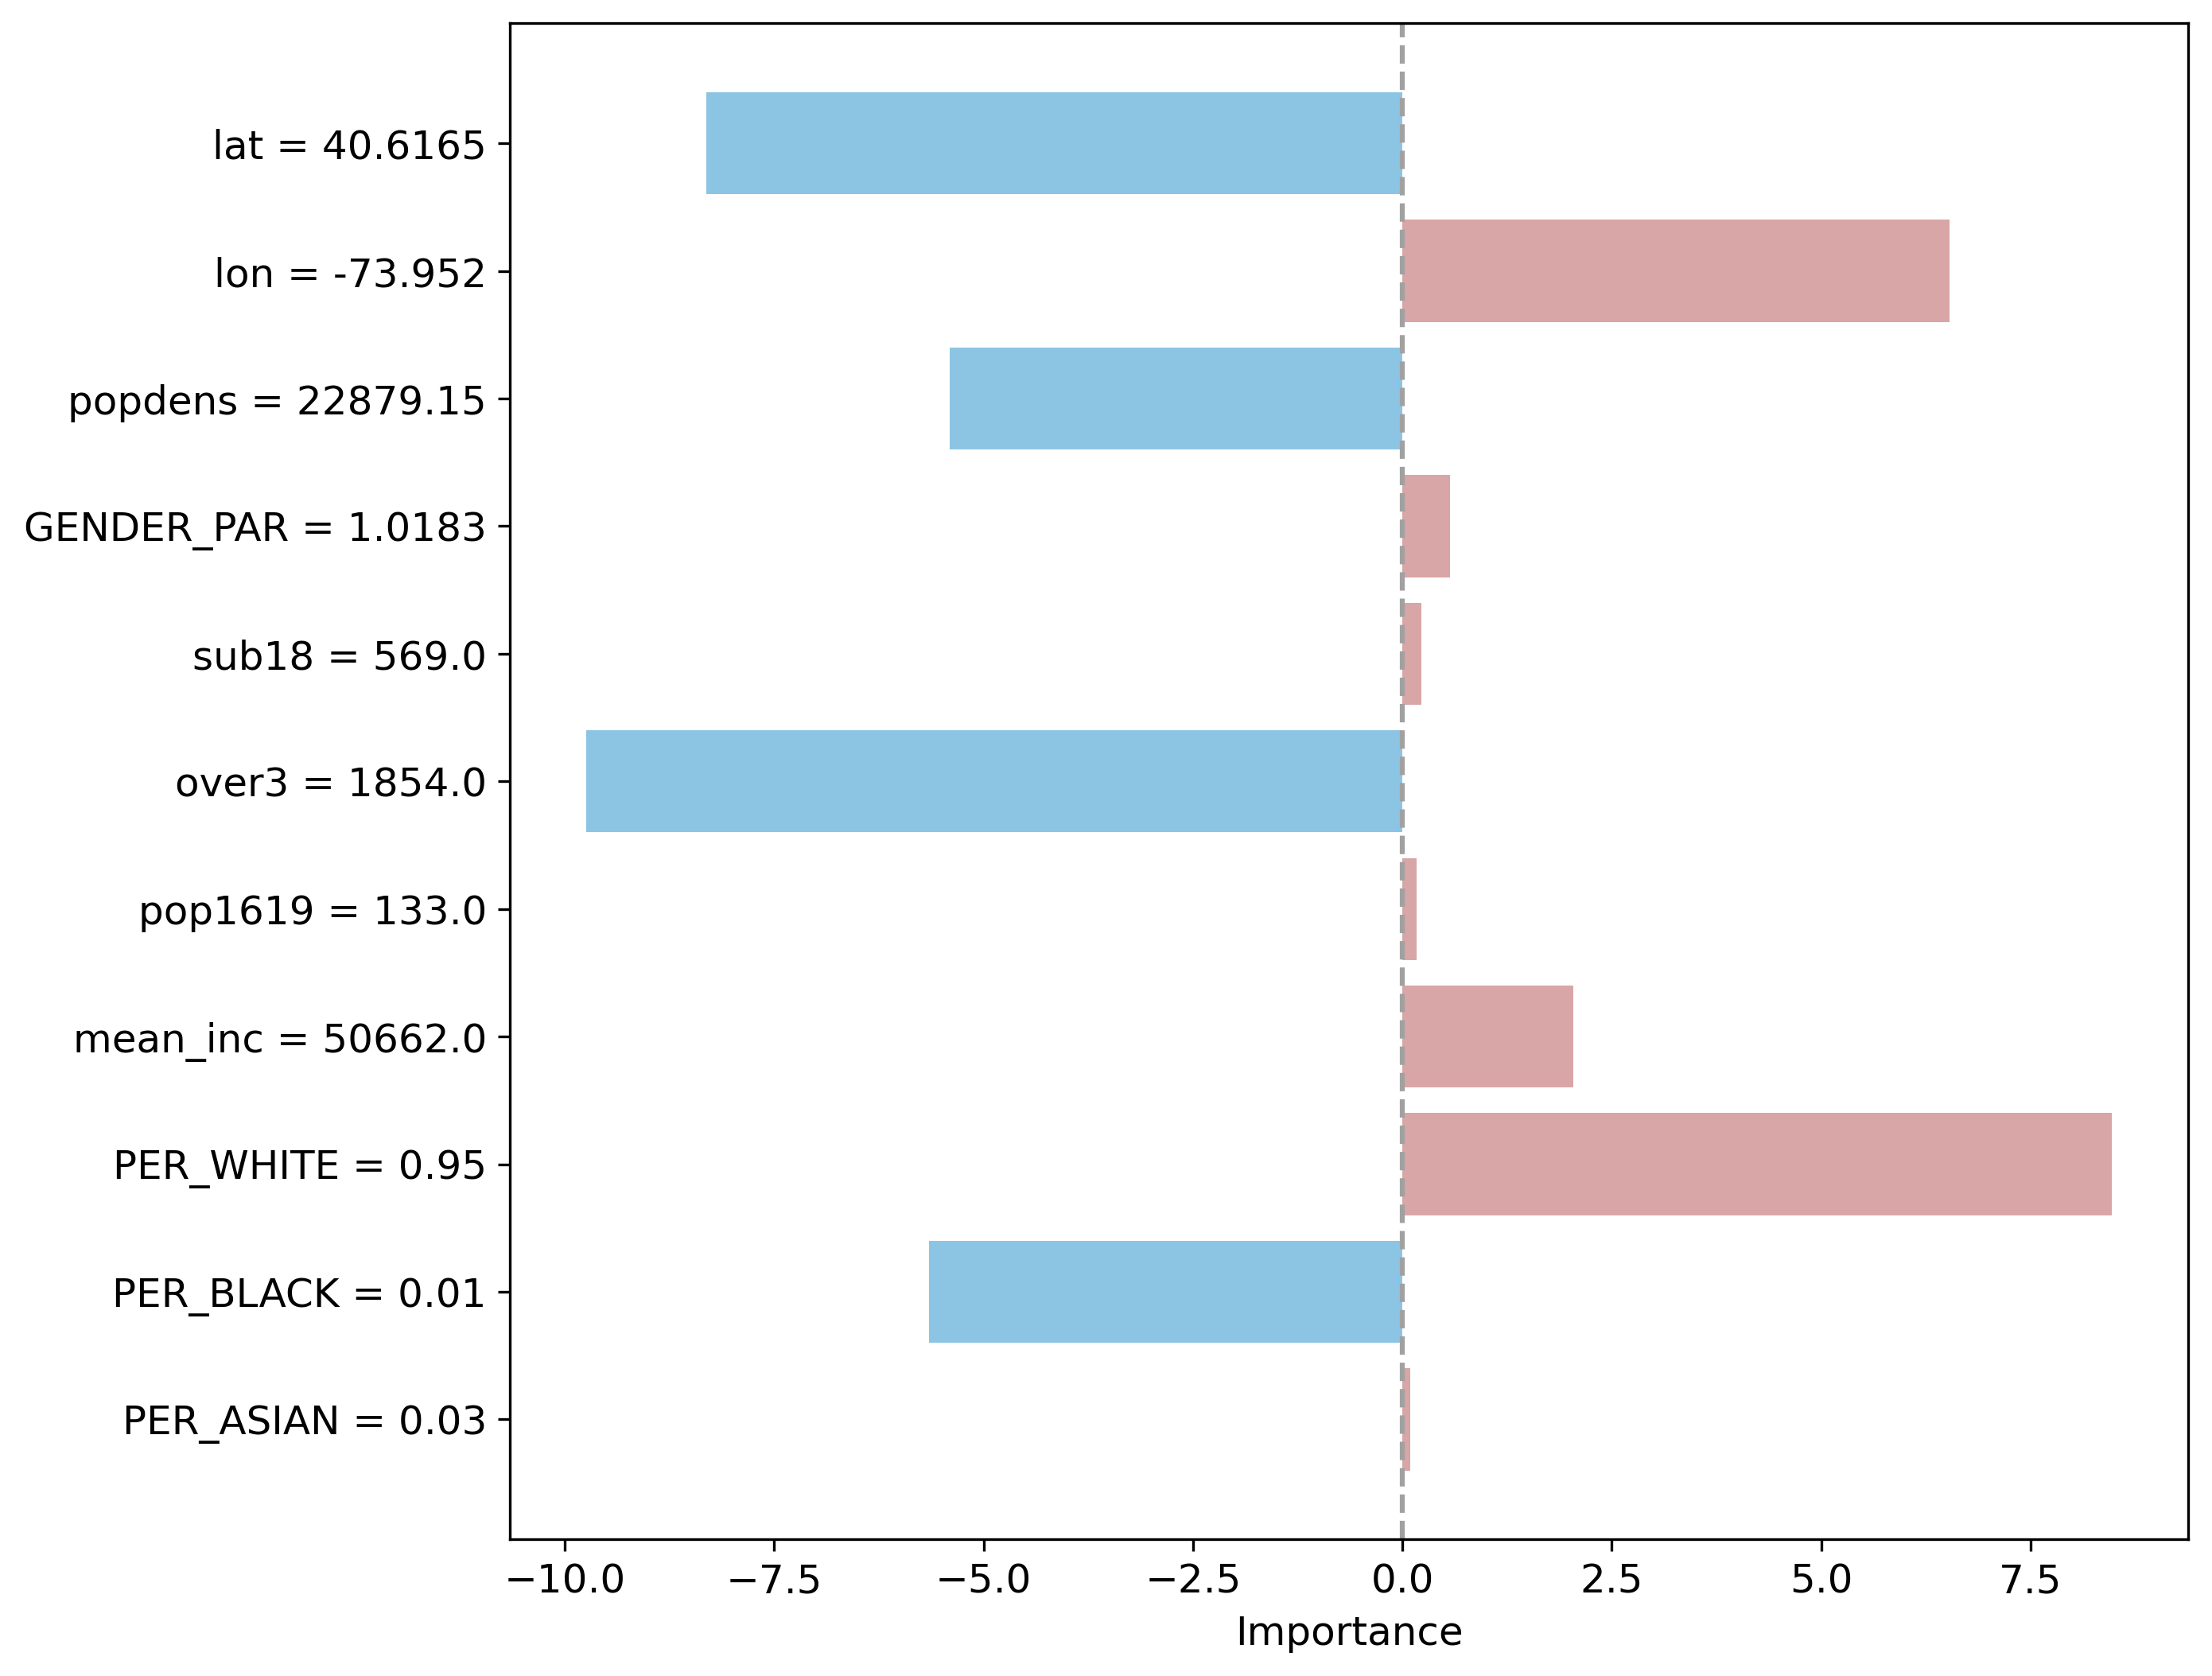

In [31]:
plot_shap_values_without_uncertainty(feature_values, shap_values, geo_uncertainty, feature_names, filename='./shap_values_without_uncertainty.pdf')

In [28]:
shap_values

array([ 0.09700078, -5.6556853 ,  8.47062982,  2.03489555,  0.16519081,
       -9.74500315,  0.22330191,  0.5691065 , -5.40809761,  6.53565198,
       -8.31381925])